In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchmetrics

In [2]:
import time

import torch
import torch.nn as nn
from torch.nn import functional as F

class ConvAttMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.bn1= nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
        
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.pool1 = nn.MaxPool1d(3,stride=3)
        self.bn4=nn.BatchNorm1d(3300)
        self.conv2 = nn.Conv1d(8, 16, 5,padding=2)
        self.bn5=nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3,stride=3)
        self.conv3=nn.Conv1d(16,1,1,stride=1)
        self.pool3=nn.MaxPool1d(3,stride=3)
        self.bn6=nn.BatchNorm1d(1100)
        #self.fc1 = nn.Linear(16*5*5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.bn7=nn.BatchNorm1d(1100)
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x=self.bn0(x)
        #print('x:',x.shape)
        x1= F.relu(self.drop(self.bn1(self.fc1(x))))
        #print('x1:',x1.shape)
        x0=torch.unsqueeze(x,1)
        x2=F.relu(self.conv1(x0))
        #x2=x2+x0
        #print('x2:',x2.shape)
        x2=F.relu(self.conv2(x2))
        #x2=x2+x0
        #print('x2:',x2.shape)
        
        
        
        avg_out = self.fc(self.avg_pool(x2))
        max_out = self.fc(self.max_pool(x2))
        out = avg_out + max_out
        x2=torch.mul(x2,out)
        x2=F.relu(self.conv3(x2))
        
        #x2=x0+x2
        
        #print('x2:',x2.shape)
        #x2=x0+x2####skip connection
        x2=torch.squeeze(x2,1)
        x2=self.bn5(x2)
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        x3=torch.add(x1,x2)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x3))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
modela=ConvAttMLP()
modela.cuda()
print(modela)

ConvAttMLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn5): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=F

In [4]:
import torch
import Trainer
from network import NFM
import torch.utils.data as Data
from Utils.criteo_loader import getTestData, getTrainData
from torch.nn import functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchmetrics
nfm_config = \
{
    'n_class':9,
    'linear_hidden1':2000,
    #'linear_hidden':100,#线性模型输出层（隐层个数）
    #'embed_input_dim':1001,#embed输入维度
    #'embed_dim': 100, # 用于控制稀疏特征经过Embedding层后的稠密特征大小，embed输出维度
    #'dnn_hidden_units': [100,11],#MLP隐层和输出层
    
    'dnn_hidden_units':[100,9],#MLP隐层
    'num_sparse_features_cols':10477,#the number of the gene columns
    'num_dense_features': 0,#dense features number
    'bi_dropout': 0.5,#Bi-Interaction 的dropout
    'num_epoch': 500,#训练epoch次数
    'batch_size': 16,#batch_size
    'lr': 1e-3,
    'l2_regularization': 1e-4,
    'device_id': 0,
    'use_cuda': False,
    'epoch':1000,
    
    #'train_file': '../Data/criteo/processed_data/train_set.csv',
    #'fea_file': '../Data/criteo/processed_data/fea_col.npy',
    #'validate_file': '../Data/criteo/processed_data/val_set.csv',
    #'test_file': '../Data/criteo/processed_data/test_set.csv',
    #'model_name': '../TrainedModels/NFM.model'
    #'train_file':'data/xiaoqiu_gene_5000/train/final_5000_encode_100x.csv',
    #'train_data':'dataset/qiuguan/encode/encode_1000/train/train_encode_data_1000_new.csv',
    #'train_label':'dataset/qiuguan/non_code/train/train_label.csv',
    #'guan_test_data':'dataset/qiuguan/non_code/guan_test/guan_test_data.csv',
    #'guan_test_label':'dataset/qiuguan/non_code/guan_test/guan_test_label.csv',
    #'test_data':'dataset/qiuguan/encode/encode_1000/test/test_encode_data_1000_new.csv',
    #'test_label':'dataset/qiuguan/non_code/test/test_labels.csv',
    #'title':'dataset/xiaoguan/RF/RF_for_train/train_class_9/test/test_data.csv',
    
    #'all':''
    #'title':'data/xiaoqiu_gene_5000/train/gene_5000_gene_name.csv',
    #'all':'data/xiaoqiu_gene_5000/train/gene_5000_label_name.csv'
}

#model definition
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model = MLP().cuda()
#print(model)

class MLP1(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(237)
        self.fc1 = nn.Linear(237, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model1 = MLP1().cuda()
print(model1)
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(126)
        self.fc1 = nn.Linear(126, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model2 = MLP2().cuda()
#print(model2)


class MLP3(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(177)
        self.fc1 = nn.Linear(177, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model3 = MLP3().cuda()
#print(model3)

class MLP4(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(130)
        self.fc1 = nn.Linear(130, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model4 = MLP4().cuda()

class MLP5(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(172)
        self.fc1 = nn.Linear(172, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model5 = MLP5().cuda()
import time

import torch
import torch.nn as nn
from torch.nn import functional as F







#print(model4)
import os
import time
import argparse
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import torch.nn.functional as F  # 激励函数的库
#import network
import config
import evaluate
import data_utils
#import Trainer



def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output


def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output



class KZDatasetPredict(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, df_list):
    
       
        self.data_info = self.get_data_info(df_list)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data,label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data,label

    def __len__(self):
        return len(self.data_info)
   
    
    
    def get_data_info(self,df_list):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        print('data_info:',df_list[-1])
        #df=pd.read_csv(csv_path,sep=',')
        #df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        label=int(df_list[-1])
        labels.append(label)
        print('labels:',labels)
        data=df_list[:-1]
        #df_np=np.array(df_list)
        #print(rows,cols)
        
        #print('labels:',labels)
        labels=np.array(labels)
        print('labels.shape:',labels.shape)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        
           
        
        data=np.array(data)#
            
            
            
            
            
            
            
            
        data=torch.from_numpy(data)#
            
        labels=torch.from_numpy(labels)#
        #bi_data=embding_process(nfm_config,data)
        #print("bi_data.shape:",bi_data.shape)
            
            
        data_info.append((data,label))
        return data_info
class KZDatasetTest(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, csv_path):
    
       
        self.data_info = self.get_data_info(csv_path)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
   
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',')
        df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
import torch
import torch.nn as nn
from torch.utils.data.dataset import *
from PIL import Image
from torch.nn import functional as F
import random
from sklearn.model_selection import train_test_split
import ast
import torchvision


        

class KZDataset(Dataset):
    def __init__(self, csv_path, K,n_class,ki=0, typ='train', transform=None, rand=False):
       
        self.all_data_info = self.get_data_info(csv_path)
        
        if rand:
            random.seed(1)
            random.shuffle(self.all_data_info)
        leng = len(self.all_data_info)
        every_z_len = leng // K
        if typ == 'val':
            self.data_info = self.all_data_info[every_z_len * ki : every_z_len * (ki+1)]
        elif typ == 'train':
            self.data_info = self.all_data_info[: every_z_len * ki] + self.all_data_info[every_z_len * (ki+1) :]
            
        self.transform = transform
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',')
        df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
    
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
#from new_nfm_network import NFM
import os
import time
import argparse
import numpy as np
import pandas as pd 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
#import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter

#import torchmetrics
            

from torchmetrics.classification import accuracy

def train_epoch(model,train_loader,batch_size,optimizer,loss_func):
    BATCH_SIZE=batch_size
    total = 0
    correct=0
    total_loss=0
    #
    model.train()
    total_train_accuracy=0  
    for batch_idx, (x, labels) in enumerate(train_loader):
            
        labels = Variable(labels)
        x = Variable(x)
            
            
        x=torch.tensor(x,dtype=torch.float)
        labels=torch.tensor(labels,dtype=torch.float)
        x, labels = x.cuda(), labels.cuda()
        labels_int=labels=torch.max(labels,1)[1]
            
            
        optimizer.zero_grad()
        y_predict = model(x)
            
        loss = loss_func(y_predict, labels)
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
           

        total_loss += loss
            
            
            
        #
        '''
        train_acc_en=torchmetrics.Accuracy(task='multiclass',num_classes=9).cuda()
        batch_train_acc=train_acc_en(y_predict,labels_int)
        '''
        batch_train_acc=torchmetrics.functional.accuracy(y_predict,labels_int)
        #batch_train_acc=torchmetrics.classification.Accuracy(y_predict,labels_int)
        
        
        
        #train_acc_en=accuracy(y_predict,labels_int)
        #batch_train_acc=train_acc_en()
        
        total_train_accuracy+=batch_train_acc
            
    total_train_accuracy/=(batch_idx+1)
    print('total_train_accuracy:',total_train_accuracy)
    print("Training Epoch: %d, total loss: %f" % (epoch_id, total_loss))
    return total_loss,total_train_accuracy

def val_epoch(model,test_loader,batch_size,optimizer): 
    batch_size_num=0
    total_test_acc=0
    model.eval()
    for i , (inputs , targets) in enumerate(test_loader):   
            print("test")
            
            inputs = Variable(inputs)   
            targets = Variable(targets)     
           
            inputs=torch.tensor(inputs ,dtype=torch.float)   
            targets=torch.tensor(targets ,dtype=torch.float)   
            inputs , targets = inputs.cuda(),  targets.cuda()   
            yhat = model(inputs)  
            
            
            
            targets=torch.max(targets,1)[1]
            
            
            
            #test_acc_en=torchmetrics.Accuracy(task='multiclass',num_classes=9).cuda()
            batch_test_acc=torchmetrics.functional.accuracy(yhat,targets)
            
            total_test_acc+=batch_test_acc
            
            batch_size_num=i
    total_test_acc/=(batch_size_num+1)
        ###print('total_test_accuracy:',total_test_acc/(batch_size+1))
    print('total_test_accuracy:',total_test_acc)
        
                    
                    
            
            
    
        
   
    
    return total_test_acc


import numpy as np
import math
import matplotlib.pyplot as plt

def plotLoss(loss,epoch):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(8, 5))
    x=[i for i in range(epoch)]
    #acc_train=acc_train.cpu()
    #acc_test=acc_test.cpu()
    plt.plot(x, loss, 'r-', mec='k', label='Logistic Loss', lw=2)
    #plt.plot(x,acc_train,'b-',mec='k',label='accuracy Train',lw=2)
    #plt.plot(x,acc_test,'g-',mec='k',label='accuracy Test',lw=2)
    #plt.plot(x, y_01, 'g-', mec='k', label='0/1 Loss', lw=2)
    #plt.plot(x, y_hinge, 'b-',mec='k', label='Hinge Loss', lw=2)
    #plt.plot(x, boost, 'm--',mec='k', label='Adaboost Loss',lw=2)
    plt.grid(True, ls='--')
    plt.legend(loc='upper right')
    plt.title('损失函数')
    plt.show()
 


MLP1(
  (bn0): BatchNorm1d(237, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=237, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


549 3301
549 3301


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:330: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


total_train_accuracy: tensor(0.1479, device='cuda:0')
Training Epoch: 0, total loss: 65.856437
total_train_accuracy: tensor(0.1708, device='cuda:0')
Training Epoch: 1, total loss: 65.412014
total_train_accuracy: tensor(0.2000, device='cuda:0')
Training Epoch: 2, total loss: 64.754957
total_train_accuracy: tensor(0.2604, device='cuda:0')
Training Epoch: 3, total loss: 63.889077
total_train_accuracy: tensor(0.3250, device='cuda:0')
Training Epoch: 4, total loss: 63.210488
total_train_accuracy: tensor(0.3354, device='cuda:0')
Training Epoch: 5, total loss: 62.840601
total_train_accuracy: tensor(0.3688, device='cuda:0')
Training Epoch: 6, total loss: 62.042665
total_train_accuracy: tensor(0.4063, device='cuda:0')
Training Epoch: 7, total loss: 61.625580
total_train_accuracy: tensor(0.4500, device='cuda:0')
Training Epoch: 8, total loss: 60.941337
total_train_accuracy: tensor(0.4646, device='cuda:0')
Training Epoch: 9, total loss: 60.559912
total_train_accuracy: tensor(0.4938, device='cuda:

total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 86, total loss: 46.768149
total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 87, total loss: 47.083731
total_train_accuracy: tensor(0.8938, device='cuda:0')
Training Epoch: 88, total loss: 46.517676
total_train_accuracy: tensor(0.8833, device='cuda:0')
Training Epoch: 89, total loss: 47.093300
total_train_accuracy: tensor(0.8708, device='cuda:0')
Training Epoch: 90, total loss: 47.262665
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 91, total loss: 47.103014
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 92, total loss: 46.950753
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 93, total loss: 46.517577
total_train_accuracy: tensor(0.9000, device='cuda:0')
Training Epoch: 94, total loss: 46.396162
total_train_accuracy: tensor(0.8917, device='cuda:0')
Training Epoch: 95, total loss: 46.696616
total_train_accuracy: tensor(0.9125, dev

/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0, 

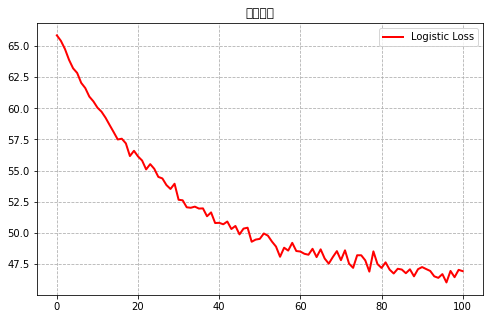

test
test
test
total_test_accuracy: tensor(0.7500, device='cuda:0')
acc_test_each_k: tensor(0.7500, device='cuda:0')


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


549 3301
549 3301
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 0, total loss: 46.639578
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 1, total loss: 47.412000
total_train_accuracy: tensor(0.8875, device='cuda:0')
Training Epoch: 2, total loss: 46.516699
total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 3, total loss: 46.642232
total_train_accuracy: tensor(0.8792, device='cuda:0')
Training Epoch: 4, total loss: 46.963910
total_train_accuracy: tensor(0.8708, device='cuda:0')
Training Epoch: 5, total loss: 46.818905
total_train_accuracy: tensor(0.8792, device='cuda:0')
Training Epoch: 6, total loss: 46.714797
total_train_accuracy: tensor(0.8958, device='cuda:0')
Training Epoch: 7, total loss: 46.600421
total_train_accuracy: tensor(0.8729, device='cuda:0')
Training Epoch: 8, total loss: 46.556966
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 9, total loss: 45.905675
total_train_accuracy: tensor(0.8

total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 86, total loss: 44.120992
total_train_accuracy: tensor(0.9313, device='cuda:0')
Training Epoch: 87, total loss: 44.221727
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 88, total loss: 43.801498
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 89, total loss: 43.836726
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 90, total loss: 43.681763
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 91, total loss: 43.866473
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 92, total loss: 43.652581
total_train_accuracy: tensor(0.9417, device='cuda:0')
Training Epoch: 93, total loss: 43.978988
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 94, total loss: 43.743081
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 95, total loss: 43.568085
total_train_accuracy: tensor(0.9688, dev

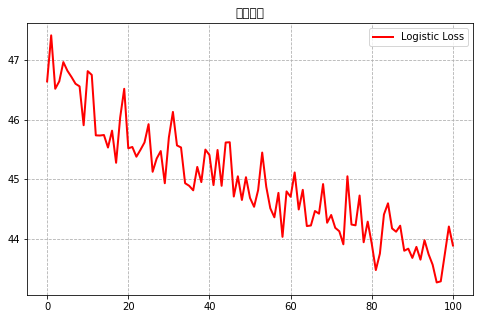

test
test
test
total_test_accuracy: tensor(0.9375, device='cuda:0')
acc_test_each_k: tensor(0.9375, device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 0, total loss: 44.327781
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 1, total loss: 43.940893
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 2, total loss: 43.682370
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 3, total loss: 43.696166
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 4, total loss: 44.078258
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 5, total loss: 43.759288
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 6, total loss: 44.284924
total_train_accuracy: tensor(0.9313, device='cuda:0')
Training Epoch: 7, total loss: 44.435230
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 8, total loss: 43.783685
total_trai

total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 85, total loss: 43.417131
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 86, total loss: 43.044519
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 87, total loss: 43.453138
total_train_accuracy: tensor(0.9333, device='cuda:0')
Training Epoch: 88, total loss: 43.707287
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 89, total loss: 42.743628
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 90, total loss: 43.087768
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 91, total loss: 43.360423
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 92, total loss: 43.028027
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 93, total loss: 43.148922
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 94, total loss: 43.438630
total_train_accuracy: tensor(0.9750, dev

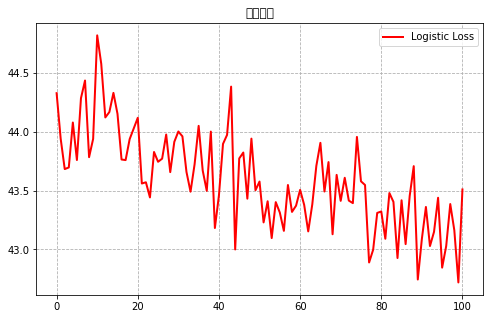

test
test
test
total_test_accuracy: tensor(0.9583, device='cuda:0')
acc_test_each_k: tensor(0.9583, device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 0, total loss: 43.630138
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 1, total loss: 43.473676
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 2, total loss: 43.449848
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 3, total loss: 43.020615
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 4, total loss: 43.084576
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 5, total loss: 42.896100
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 6, total loss: 43.151246
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 7, total loss: 43.264295
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 8, total loss: 43.032465
total_trai

total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 85, total loss: 42.454490
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 86, total loss: 42.461253
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 87, total loss: 42.584838
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 88, total loss: 42.730467
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 89, total loss: 42.744949
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 90, total loss: 42.369982
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 91, total loss: 43.021426
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 92, total loss: 43.034520
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 42.736519
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 94, total loss: 42.739773
total_train_accuracy: tensor(0.9646, dev

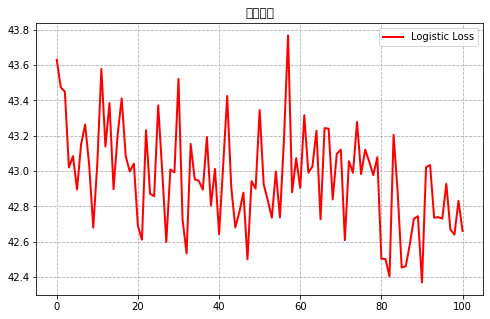

test
test
test
total_test_accuracy: tensor(0.9792, device='cuda:0')
acc_test_each_k: tensor(0.9792, device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 0, total loss: 42.945475
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 1, total loss: 43.069377
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 2, total loss: 42.981064
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 3, total loss: 42.502505
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 4, total loss: 43.033918
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 5, total loss: 43.481884
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 6, total loss: 43.034782
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 7, total loss: 42.768078
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 8, total loss: 42.969725
total_trai

total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 85, total loss: 42.163445
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 86, total loss: 42.416678
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 87, total loss: 43.089229
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 88, total loss: 42.392742
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 89, total loss: 42.406822
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 90, total loss: 42.527328
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 91, total loss: 42.901113
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 92, total loss: 42.397472
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 93, total loss: 42.347633
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 94, total loss: 43.035243
total_train_accuracy: tensor(0.9667, dev

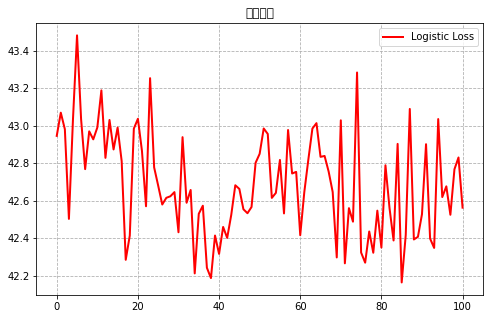

test
test
test
total_test_accuracy: tensor(0.9583, device='cuda:0')
acc_test_each_k: tensor(0.9583, device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 0, total loss: 42.964508
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 1, total loss: 43.116580
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 2, total loss: 42.969585
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 3, total loss: 42.661985
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 4, total loss: 42.308709
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 5, total loss: 42.569384
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 6, total loss: 42.446723
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 7, total loss: 43.034440
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 8, total loss: 42.771100
total_trai

total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 85, total loss: 42.925136
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 86, total loss: 42.913159
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 87, total loss: 42.862760
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 88, total loss: 42.706435
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 89, total loss: 42.662699
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 90, total loss: 42.787639
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 91, total loss: 42.209983
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 92, total loss: 42.503480
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 93, total loss: 42.893661
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 94, total loss: 42.604286
total_train_accuracy: tensor(0.9708, dev

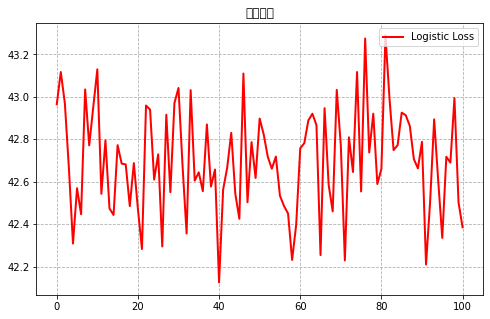

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 0, total loss: 42.981401
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 1, total loss: 42.906649
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 2, total loss: 42.936446
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 3, total loss: 42.971282
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 4, total loss: 42.469246
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 5, total loss: 42.661673
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 6, total loss: 43.120913
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 7, total loss: 43.239815
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 8, total loss: 42.875157
total_train_accura

total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 85, total loss: 42.305023
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 86, total loss: 42.175727
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 87, total loss: 42.270503
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 88, total loss: 42.695841
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 89, total loss: 42.184668
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 90, total loss: 42.377894
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 91, total loss: 42.252269
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 92, total loss: 42.940020
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 93, total loss: 42.457426
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 94, total loss: 42.491543
total_train_accuracy: tensor(0.9729, dev

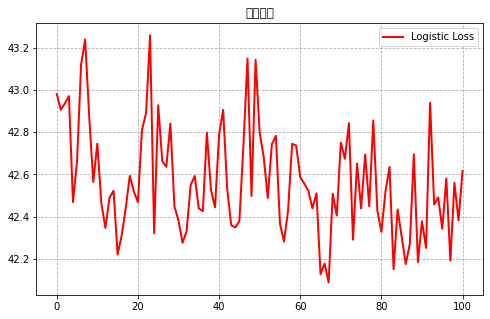

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 0, total loss: 42.546245
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 1, total loss: 42.646940
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 2, total loss: 42.498646
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 3, total loss: 42.396341
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 4, total loss: 42.531455
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 5, total loss: 42.482533
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 6, total loss: 42.371153
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 7, total loss: 42.524231
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 8, total loss: 42.415927
total_train_accura

total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 85, total loss: 42.826491
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 86, total loss: 42.137445
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 87, total loss: 42.127975
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 88, total loss: 42.209287
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 89, total loss: 42.506563
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 90, total loss: 42.407934
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 91, total loss: 42.055939
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 92, total loss: 42.412320
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 42.126307
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 94, total loss: 43.004700
total_train_accuracy: tensor(0.9729, dev

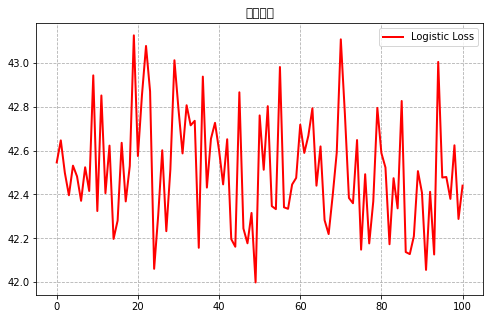

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 0, total loss: 42.727231
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 1, total loss: 42.360732
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 2, total loss: 42.465363
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 3, total loss: 42.243936
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 4, total loss: 42.262127
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 5, total loss: 42.609980
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 6, total loss: 42.678792
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 7, total loss: 42.656398
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 8, total loss: 42.865090
total_train_accura

total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 85, total loss: 42.258091
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 86, total loss: 42.592657
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 87, total loss: 41.995396
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 88, total loss: 42.205078
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 89, total loss: 42.691548
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 90, total loss: 42.822435
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 91, total loss: 42.383728
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 92, total loss: 42.412705
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 42.383186
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 94, total loss: 42.439952
total_train_accuracy: tensor(0.9854, dev

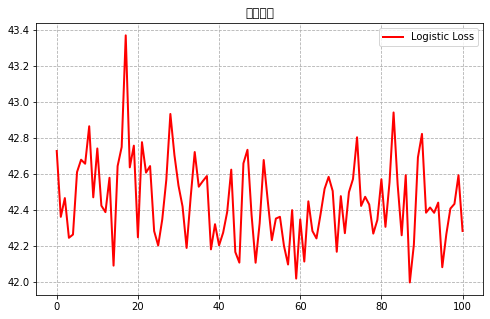

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 3301
549 3301
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 0, total loss: 42.494209
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 1, total loss: 42.112574
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 2, total loss: 42.124981
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 3, total loss: 42.564260
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 4, total loss: 42.528264
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 5, total loss: 42.234790
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 6, total loss: 42.586865
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 7, total loss: 42.167598
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 8, total loss: 42.317185
total_train_accura

total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 85, total loss: 42.964615
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 86, total loss: 42.135845
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 87, total loss: 42.094720
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 88, total loss: 42.663446
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 89, total loss: 42.586957
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 90, total loss: 42.742681
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 91, total loss: 42.490376
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 92, total loss: 42.422708
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 93, total loss: 42.253719
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 94, total loss: 42.384516
total_train_accuracy: tensor(0.9813, dev

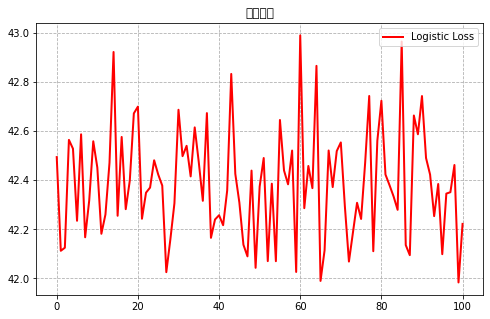

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
[tensor(0.7500, device='cuda:0'), tensor(0.9375, device='cuda:0'), tensor(0.9583, device='cuda:0'), tensor(0.9792, device='cuda:0'), tensor(0.9583, device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
[array(0.75, dtype=float32), array(0.9375, dtype=float32), array(0.9583334, dtype=float32), array(0.9791667, dtype=float32), array(0.9583334, dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]
acc_test_metrics: 0.9583334


In [25]:
model=modela
K=10
test_metrics=[]
train_loss_total_list=[]
for ki in range(K):
    trainset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv',K=K, n_class=nfm_config['n_class'],ki=ki,  typ='train', transform=None, rand=True)
    valset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv', K=K,n_class=nfm_config['n_class'],ki=ki,  typ='val', transform=None, rand=True)
    train_loader = data.DataLoader(
         dataset=trainset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size'],
         shuffle=True)
    val_loader = data.DataLoader(
         dataset=valset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
    
    model_path='models/ConvAttMLP/'
    #BATCH_SIZE=batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=nfm_config['lr'], weight_decay=nfm_config['l2_regularization'])
    #total = 0
    
    
    loss_func=torch.nn.CrossEntropyLoss()
    
    num=0
   
    
    epoches=101
    for epoch_id in range(epoches):
          
        
        
        train_loss_total,acc_train=train_epoch(model,train_loader,nfm_config['batch_size'],optimizer,loss_func)
        train_loss_total_list.append(train_loss_total)#
        if epoch_id %20==0:
            num=num+1
            #path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pkl')
            #torch.save(model.state_dict(),path)
            # 保存模型
            
            path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pt')##################pt
            torch.save(model.state_dict(),path)
            #torch.save(model.state_dict(),path)
    print("the ",ki," epoch ends")
    plotLoss(train_loss_total_list,epoches)
    train_loss_total_list=[]
    acc_test=val_epoch(model,val_loader,nfm_config['batch_size'],optimizer)
    print("acc_test_each_k:",acc_test)
    test_metrics.append(acc_test)

print(test_metrics)
#test_metrics=test_metrics.tolist()
test_metrics=[x.cpu().detach().numpy() for x in test_metrics]
print(test_metrics)
acc_test_metrics=np.mean(test_metrics) 
print("acc_test_metrics:",acc_test_metrics)
       


ConvAttMLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn5): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=F

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

f1_score:  %.4f 0.905846553010994
accuracy_score: 0.9130434782608695
recall_score: 0.903781512605042
pre_recall: 0.9188516324481236
n_classes: 9


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


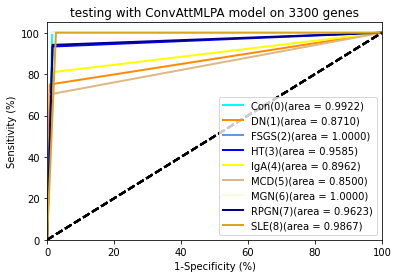

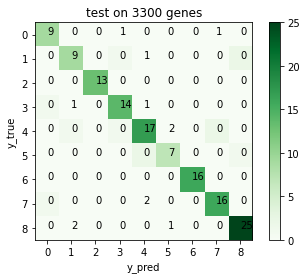

In [5]:
import torch

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'
path='models/ConvAttMLP/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with ConvAttMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()

In [6]:
#find the means for the predicted correctly
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def bool_predict_model(test_dl, model): 
    model.eval()#测试数据稳定
    error_dataset=torch.tensor([0])
    error_dataset=error_dataset.view(1,1)
    predictions, actuals = [], [] 
    num=0
    for i, (inputs,targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        #bi_inputs=Variable(bi_inputs)
        targets = Variable(targets) 
        #print(targets)
        #print('targets:',targets.shape)        
        #targets=targets.argmax(axis=1)  
        #print('targets:',targets.shape)
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        #bi_inputs=torch.tensor(bi_inputs,dtype=torch.float)
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(),targets.cuda() 
        yhat = model(inputs) 
        
        yhat=yhat.argmax(axis=1)
        print('yhat:',yhat.shape)
        
        if targets==yhat:
            return True
        else:
            return False
#find

In [7]:
#find the samples that predicted correctly
import pandas as pd 
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info1.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
#mlp=MLP()
model=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
model.load_state_dict(torch.load(path),strict=False)
model.cuda()

print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model


#testset = KZDatasetPredict(test_df)
''''
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
'''
false_list=[]
for i in range(rows):
    df_list=test_df.iloc[i,:].tolist()
    print(type(df_list))
    print('df_list:',df_list[-1])
    #print(data_set)
    print('this is data_set')
    data_set = KZDatasetPredict(df_list)
    data_test_loader=data.DataLoader(dataset=data_set,
                                    batch_size=1)
    print(data_test_loader)
    bool_index=bool_predict_model(data_test_loader,model)
    print(bool_index)
    if bool_index==False:
        
        false_list.append(i)
        #test_df=test_df.drop(index=i, inplace=True)
        
for i,aitem in enumerate(false_list):
    test_df.drop(index=i, inplace=True)
print(test_df.shape)   

test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv')

138 3301
ConvAttMLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn5): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ce

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
this is data_set
data_info: 3.0
labels: [3]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 0.0
this is data_set
data_info: 0.0
labels: [0]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 8.0
this is data_set
data_info: 8.0
labels: [8]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 2.0
this is data_set
data_info: 2.0
labels: [2]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 1.0
this is data_set
data_info: 1.0
labels: [1]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 4.0
this is data_set
data_info: 4.0
labels: [4]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 0.0
this is data_set
data_info: 0.0
labels: [0]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 8.0
this is data_set
data_info: 8.0
labels: [8]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 0.0
t

yhat: torch.Size([1])
False
<class 'list'>
df_list: 2.0
this is data_set
data_info: 2.0
labels: [2]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 6.0
this is data_set
data_info: 6.0
labels: [6]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 2.0
this is data_set
data_info: 2.0
labels: [2]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 7.0
this is data_set
data_info: 7.0
labels: [7]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 8.0
this is data_set
data_info: 8.0
labels: [8]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 1.0
this is data_set
data_info: 1.0
labels: [1]
labels.shape: (1,)
yhat: torch.Size([1])
False
<class 'list'>
df_list: 2.0
this is data_set
data_info: 2.0
labels: [2]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
this is data_set
data_info: 3.0
labels: [3]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 5.0

yhat: torch.Size([1])
True
<class 'list'>
df_list: 6.0
this is data_set
data_info: 6.0
labels: [6]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 5.0
this is data_set
data_info: 5.0
labels: [5]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 6.0
this is data_set
data_info: 6.0
labels: [6]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 5.0
this is data_set
data_info: 5.0
labels: [5]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 2.0
this is data_set
data_info: 2.0
labels: [2]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 4.0
this is data_set
data_info: 4.0
labels: [4]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 8.0
this is data_set
data_info: 8.0
labels: [8]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
this is data_set
data_info: 3.0
labels: [3]
labels.shape: (1,)
yhat: torch.Size([1])
True
<class 'list'>
df_list: 6.0
t

In [8]:
#compute mean value of all the correctly predicted samples:
import pandas as pd 
import torch
import numpy as np
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
columns=test_df.columns[:-1].tolist()
#columns=torch.tensor(columns).cuda()#ValueError: too many dimensions 'str'


row_mean=test_df.mean(axis=0)
print(row_mean)
row_mean=row_mean[:-1]#drop off label
row_mean_np=np.array(row_mean).reshape(1,-1)
print(row_mean_np)
row_mean_df=pd.DataFrame(row_mean_np)
print(row_mean_df)
row_mean_df.columns=test_df.columns[:-1]
print(row_mean_df)
row_mean_tensor=torch.from_numpy(row_mean_np).cuda()
row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)
#去掉行




#compute contribution using the Equ.
import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
model=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
model.load_state_dict(torch.load(path),strict=False)
model.cuda()

print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model



weight={}
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())
    #names.append(name)
    weight[name]=parameters
print("weight:",weight)
#q
'''
bn0.weight : torch.Size([3300])
bn0.bias : torch.Size([3300])
fc1.weight : torch.Size([2000, 3300])
fc1.bias : torch.Size([2000])
bn1.weight : torch.Size([2000])
bn1.bias : torch.Size([2000])
fc2.weight : torch.Size([100, 2000])
fc2.bias : torch.Size([100])
bn2.weight : torch.Size([100])
bn2.bias : torch.Size([100])
fc3.weight : torch.Size([9, 100])
fc3.bias : torch.Size([9])
bn3.weight : torch.Size([9])
bn3.bias : torch.Size([9])
'''






def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    n = len(labels)
    #n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output







l3=torch.mm(weight['fc3.weight'],weight['fc2.weight'][:,:1100])
print('l3:',l3.shape)
l2=torch.mm(l3,weight['fc1.weight'])
print('l2:',l2.shape)
contri_k=[]
contri_k_names=[]
for i in range(nfm_config['n_class']):
    l1=torch.mm(l2,row_mean_tensor.T)
    uu=l2[i,:]*row_mean_tensor.reshape(3300)
    print(uu.shape)
    top_k=torch.topk(uu,20,largest=True)#################20
    print('top_k:',top_k)
    
    contri_k.append(top_k)
    top_k_indices=top_k.indices.cpu().detach().numpy().tolist()
    print('top_k_indices:',top_k_indices)
    top_k_names=[columns[j] for j in top_k_indices]
    print(top_k_names)
    contri_k_names.append(top_k_names)

contri_k_names_np=np.array(contri_k_names)
print(contri_k_names_np.shape)

contri_k_names_df=pd.DataFrame(contri_k_names_np)
contri_k_names_df.to_csv('results_genes/ConvAttMLP/contri_20_names_df.csv')
#from chartGPT of the following code
result = set()
for sublist in contri_k_names:
    result = result.union(sublist)

# 或者使用集合的union方法的更简洁写法，使用集合解析
# result = set().union(*list_of_lists)

# 或者使用 | 运算符
# result = set().union(*list_of_lists)

# 将结果转回列表
result_list = list(result)

print(result_list)

import csv
csv_filename = "results_genes/ConvAttMLP/genes_all_20_mean.csv"

# 使用CSV模块保存列表为CSV文件
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(result_list)

#这将输出所有列表的并集，不包含重复的元素。在这个例子中，结果会是 [1, 2, 3, 4, 5, 6, 7]。你可以根据你的实际需求将这个结果转换为列表或者保留为集合，具体取决于你的应用场景。
#抽取训练集和测试集中的数据

#生成新选取元素的数据集
train_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'
test_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv'

train_df=pd.read_csv(train_path,sep=',')
train_df1=train_df
print(train_df1.columns)
train_df=train_df.iloc[:,1:]
train_df1=train_df1.iloc[:,1:-1]

columns=result_list
columns.append('label')
print(columns)


train_df2=train_df[columns]
print(train_df2.shape)
train_df2.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/train_val_info.csv')

test_df=pd.read_csv(test_path,sep=',')

test_df=test_df.iloc[:,1:]



test_df=test_df[columns]
print(test_df.shape)
test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info.csv')





129 3301
RHOA       11.718654
STX2        7.554857
CISD1       9.574166
WDR11       8.211014
SCYL2       6.843801
             ...    
SULT1A1    10.176426
AMOT       11.457798
CA1         6.462708
GPR35       5.410572
label       4.558140
Length: 3301, dtype: float64
[[11.71865387  7.55485654  9.57416624 ... 11.45779827  6.46270762
   5.41057152]]
        0         1         2         3         4         5         6     \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       7         8         9     ...      3290      3291      3292      3293  \
0  5.549722  4.999493  6.581626  ...  8.137269  6.165143  7.996614  6.371971   

       3294      3295       3296       3297      3298      3299  
0  7.569604  6.658189  10.176426  11.457798  6.462708  5.410572  

[1 rows x 3300 columns]
        RHOA      STX2     CISD1     WDR11     SCYL2   MGC2889    CCDC47  \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       KLF8      CCL1   S

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([3300])
top_k: torch.return_types.topk(
values=tensor([25.0690, 22.8064, 22.7217, 21.4464, 21.0584, 19.9567, 17.9271, 17.2110,
        16.9928, 16.9866, 16.8373, 16.5269, 15.4862, 15.4330, 15.2337, 14.9387,
        14.8047, 14.7743, 14.7350, 14.5315], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([1150, 1152,  823, 1818, 1609,  103, 3288,  257, 2711, 2960, 2980,  726,
        2076,  572, 2546, 1643, 1467,  951, 2559, 3238], device='cuda:0'))
top_k_indices: [1150, 1152, 823, 1818, 1609, 103, 3288, 257, 2711, 2960, 2980, 726, 2076, 572, 2546, 1643, 1467, 951, 2559, 3238]
['LHPP', 'LGMN', 'CHP1', 'ZNHIT1', 'CTSG', 'IFI6', 'RGS5', 'CYP2J2', 'CPVL', 'RPS27L', 'TDP2', 'AGL', 'CRABP2', 'ACKR1', 'MST1L', 'VAMP8', 'MEST', 'CHODL', 'TYR', 'MS4A4A']
torch.Size([3300])
top_k: torch.return_types.topk(
values=tensor([28.8737, 25.4811, 23.2466, 22.7512, 20.8991, 20.5893, 20.5677, 20.4039,
        20.1702, 19.5677, 19.0753, 18.2577, 18.1311, 18.1291, 17.6533, 17.0435,
   

(138, 127)


In [9]:
#compute mean value of all the correctly predicted samples:
import pandas as pd 
import torch
import numpy as np
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
columns=test_df.columns[:-1].tolist()
#columns=torch.tensor(columns).cuda()#ValueError: too many dimensions 'str'


row_mean=test_df.mean(axis=0)
print(row_mean)
row_mean=row_mean[:-1]#drop off label
row_mean_np=np.array(row_mean).reshape(1,-1)
print(row_mean_np)
row_mean_df=pd.DataFrame(row_mean_np)
print(row_mean_df)
row_mean_df.columns=test_df.columns[:-1]
print(row_mean_df)
row_mean_tensor=torch.from_numpy(row_mean_np).cuda()
row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)
#去掉行




#compute contribution using the Equ.
import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
model=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
model.load_state_dict(torch.load(path),strict=False)
model.cuda()

print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model



weight={}
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())
    #names.append(name)
    weight[name]=parameters
print("weight:",weight)
#q
'''
bn0.weight : torch.Size([3300])
bn0.bias : torch.Size([3300])
fc1.weight : torch.Size([2000, 3300])
fc1.bias : torch.Size([2000])
bn1.weight : torch.Size([2000])
bn1.bias : torch.Size([2000])
fc2.weight : torch.Size([100, 2000])
fc2.bias : torch.Size([100])
bn2.weight : torch.Size([100])
bn2.bias : torch.Size([100])
fc3.weight : torch.Size([9, 100])
fc3.bias : torch.Size([9])
bn3.weight : torch.Size([9])
bn3.bias : torch.Size([9])
'''






def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    n = len(labels)
    #n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output







l3=torch.mm(weight['fc3.weight'],weight['fc2.weight'][:,:1100])
print('l3:',l3.shape)
l2=torch.mm(l3,weight['fc1.weight'])
print('l2:',l2.shape)
contri_k=[]
contri_k_names=[]
for i in range(nfm_config['n_class']):
    l1=torch.mm(l2,row_mean_tensor.T)
    uu=l2[i,:]*row_mean_tensor.reshape(3300)
    print(uu.shape)
    top_k=torch.topk(uu,20,largest=True)#################20
    print('top_k:',top_k)
    
    contri_k.append(top_k)
    top_k_indices=top_k.indices.cpu().detach().numpy().tolist()
    print('top_k_indices:',top_k_indices)
    top_k_names=[columns[j] for j in top_k_indices]
    print(top_k_names)
    contri_k_names.append(top_k_names)

contri_k_names_np=np.array(contri_k_names)
print(contri_k_names_np.shape)

contri_k_names_df=pd.DataFrame(contri_k_names_np)
contri_k_names_df.to_csv('results_genes/ConvAttMLP/contri_20_names_df.csv')
#from chartGPT of the following code
result = set()
for sublist in contri_k_names:
    result = result.union(sublist)

# 或者使用集合的union方法的更简洁写法，使用集合解析
# result = set().union(*list_of_lists)

# 或者使用 | 运算符
# result = set().union(*list_of_lists)

# 将结果转回列表
result_list = list(result)

print(result_list)

import csv
csv_filename = "results_genes/ConvAttMLP/genes_all_20_mean.csv"

# 使用CSV模块保存列表为CSV文件
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(result_list)

#这将输出所有列表的并集，不包含重复的元素。在这个例子中，结果会是 [1, 2, 3, 4, 5, 6, 7]。你可以根据你的实际需求将这个结果转换为列表或者保留为集合，具体取决于你的应用场景。
#抽取训练集和测试集中的数据

#生成新选取元素的数据集
train_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'
test_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv'

train_df=pd.read_csv(train_path,sep=',')
train_df1=train_df
print(train_df1.columns)
train_df=train_df.iloc[:,1:]
train_df1=train_df1.iloc[:,1:-1]

columns=result_list
columns.append('label')
print(columns)


train_df2=train_df[columns]
print(train_df2.shape)
train_df2.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/train_val_info.csv')

test_df=pd.read_csv(test_path,sep=',')

test_df=test_df.iloc[:,1:]



test_df=test_df[columns]
print(test_df.shape)
test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info.csv')



#compute mean value of all the correctly predicted samples:
import pandas as pd 
import torch
import numpy as np
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
columns=test_df.columns[:-1].tolist()
#columns=torch.tensor(columns).cuda()#ValueError: too many dimensions 'str'


row_mean=test_df.mean(axis=0)
print(row_mean)
row_mean=row_mean[:-1]#drop off label
row_mean_np=np.array(row_mean).reshape(1,-1)
print(row_mean_np)
row_mean_df=pd.DataFrame(row_mean_np)
print(row_mean_df)
row_mean_df.columns=test_df.columns[:-1]
print(row_mean_df)
row_mean_tensor=torch.from_numpy(row_mean_np).cuda()
row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)
#去掉行




#compute contribution using the Equ.
import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
model=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
model.load_state_dict(torch.load(path),strict=False)
model.cuda()

print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model



weight={}
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())
    #names.append(name)
    weight[name]=parameters
print("weight:",weight)
#q
'''
bn0.weight : torch.Size([3300])
bn0.bias : torch.Size([3300])
fc1.weight : torch.Size([2000, 3300])
fc1.bias : torch.Size([2000])
bn1.weight : torch.Size([2000])
bn1.bias : torch.Size([2000])
fc2.weight : torch.Size([100, 2000])
fc2.bias : torch.Size([100])
bn2.weight : torch.Size([100])
bn2.bias : torch.Size([100])
fc3.weight : torch.Size([9, 100])
fc3.bias : torch.Size([9])
bn3.weight : torch.Size([9])
bn3.bias : torch.Size([9])
'''






def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    n = len(labels)
    #n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output







l3=torch.mm(weight['fc3.weight'],weight['fc2.weight'][:,:1100])
print('l3:',l3.shape)
l2=torch.mm(l3,weight['fc1.weight'])
print('l2:',l2.shape)
contri_k=[]
contri_k_names=[]
for i in range(nfm_config['n_class']):
    l1=torch.mm(l2,row_mean_tensor.T)
    uu=l2[i,:]*row_mean_tensor.reshape(3300)
    print(uu.shape)
    top_k=torch.topk(uu,30,largest=True)#################20
    print('top_k:',top_k)
    
    contri_k.append(top_k)
    top_k_indices=top_k.indices.cpu().detach().numpy().tolist()
    print('top_k_indices:',top_k_indices)
    top_k_names=[columns[j] for j in top_k_indices]
    print(top_k_names)
    contri_k_names.append(top_k_names)

contri_k_names_np=np.array(contri_k_names)
print(contri_k_names_np.shape)

contri_k_names_df=pd.DataFrame(contri_k_names_np)
contri_k_names_df.to_csv('results_genes/ConvAttMLP/contri_30_names_df.csv')
#from chartGPT of the following code
result = set()
for sublist in contri_k_names:
    result = result.union(sublist)

# 或者使用集合的union方法的更简洁写法，使用集合解析
# result = set().union(*list_of_lists)

# 或者使用 | 运算符
# result = set().union(*list_of_lists)

# 将结果转回列表
result_list = list(result)

print(result_list)

import csv
csv_filename = "results_genes/ConvAttMLP/genes_all_30_mean.csv"

# 使用CSV模块保存列表为CSV文件
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(result_list)

#这将输出所有列表的并集，不包含重复的元素。在这个例子中，结果会是 [1, 2, 3, 4, 5, 6, 7]。你可以根据你的实际需求将这个结果转换为列表或者保留为集合，具体取决于你的应用场景。
#抽取训练集和测试集中的数据

#生成新选取元素的数据集
train_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'
test_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv'

train_df=pd.read_csv(train_path,sep=',')
train_df1=train_df
print(train_df1.columns)
train_df=train_df.iloc[:,1:]
train_df1=train_df1.iloc[:,1:-1]

columns=result_list
columns.append('label')
print(columns)


train_df2=train_df[columns]
print(train_df2.shape)
train_df2.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_train_val_info.csv')

test_df=pd.read_csv(test_path,sep=',')

test_df=test_df.iloc[:,1:]



test_df=test_df[columns]
print(test_df.shape)
test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_test_info.csv')





129 3301
RHOA       11.718654
STX2        7.554857
CISD1       9.574166
WDR11       8.211014
SCYL2       6.843801
             ...    
SULT1A1    10.176426
AMOT       11.457798
CA1         6.462708
GPR35       5.410572
label       4.558140
Length: 3301, dtype: float64
[[11.71865387  7.55485654  9.57416624 ... 11.45779827  6.46270762
   5.41057152]]
        0         1         2         3         4         5         6     \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       7         8         9     ...      3290      3291      3292      3293  \
0  5.549722  4.999493  6.581626  ...  8.137269  6.165143  7.996614  6.371971   

       3294      3295       3296       3297      3298      3299  
0  7.569604  6.658189  10.176426  11.457798  6.462708  5.410572  

[1 rows x 3300 columns]
        RHOA      STX2     CISD1     WDR11     SCYL2   MGC2889    CCDC47  \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       KLF8      CCL1   S

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


top_k_indices: [989, 103, 1333, 1089, 879, 914, 2611, 2093, 746, 2010, 916, 2437, 223, 290, 510, 2489, 699, 1270, 956, 1252]
['KLF6', 'IFI6', 'LYPLA1', 'PCK1', 'RHOB', 'GDF15', 'CHCHD3', 'CYP39A1', 'AHCYL1', 'TMEM100', 'DUSP6', 'NUDT4', 'EEF1AKMT3', 'IFI44L', 'ABCB7', 'PTP4A1', 'ADPRM', 'CFB', 'ZNRF4', 'FOS']
torch.Size([3300])
top_k: torch.return_types.topk(
values=tensor([25.0690, 22.8064, 22.7217, 21.4464, 21.0584, 19.9567, 17.9271, 17.2110,
        16.9928, 16.9866, 16.8373, 16.5269, 15.4862, 15.4330, 15.2337, 14.9387,
        14.8047, 14.7743, 14.7350, 14.5315], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([1150, 1152,  823, 1818, 1609,  103, 3288,  257, 2711, 2960, 2980,  726,
        2076,  572, 2546, 1643, 1467,  951, 2559, 3238], device='cuda:0'))
top_k_indices: [1150, 1152, 823, 1818, 1609, 103, 3288, 257, 2711, 2960, 2980, 726, 2076, 572, 2546, 1643, 1467, 951, 2559, 3238]
['LHPP', 'LGMN', 'CHP1', 'ZNHIT1', 'CTSG', 'IFI6', 'RGS5', 'CYP2J2', 'CPVL', 'RPS27

(138, 127)
129 3301
RHOA       11.718654
STX2        7.554857
CISD1       9.574166
WDR11       8.211014
SCYL2       6.843801
             ...    
SULT1A1    10.176426
AMOT       11.457798
CA1         6.462708
GPR35       5.410572
label       4.558140
Length: 3301, dtype: float64
[[11.71865387  7.55485654  9.57416624 ... 11.45779827  6.46270762
   5.41057152]]
        0         1         2         3         4         5         6     \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       7         8         9     ...      3290      3291      3292      3293  \
0  5.549722  4.999493  6.581626  ...  8.137269  6.165143  7.996614  6.371971   

       3294      3295       3296       3297      3298      3299  
0  7.569604  6.658189  10.176426  11.457798  6.462708  5.410572  

[1 rows x 3300 columns]
        RHOA      STX2     CISD1     WDR11     SCYL2   MGC2889    CCDC47  \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       KLF8   

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'bn0.weight': Parameter containing:
tensor([-0.0066,  0.0017, -0.0013,  ...,  0.0037,  0.0043, -0.0139],
       device='cuda:0', requires_grad=True), 'bn0.bias': Parameter containing:
tensor([-2.4962e-06,  1.5146e-07, -3.5950e-07,  ...,  4.0744e-07,
        -1.9973e-06, -8.5518e-07], device='cuda:0', requires_grad=True), 'fc1.weight': Parameter containing:
tensor([[ 8.4953e-03, -1.6249e-03,  8.5124e-03,  ...,  6.1140e-03,
         -1.4878e-02,  1.4500e-02],
        [-5.2298e-03, -7.3987e-04, -2.4148e-03,  ..., -5.7057e-03,
          2.2497e-02, -2.7940e-02],
        [-2.9774e-03,  8.6563e-04, -1.3885e-03,  ...,  1.3207e-04,
          4.3729e-03, -9.3832e-03],
        ...,
        [-3.0730e-40,  2.7907e-40, -2.6903e-40,  ...,  9.7102e-41,
          2.9885e-40, -8.0111e-41],
        [-2.1570e-40,  1.1788e-40,  4.7606e-40,  ..., -3.5694e-40,
         -2.9314e-40, -3.4551e-40],
        [ 1.4445e-03, -1.0203e-03,  1.5986e-02,  ...,  1.2791e-02,
         -1.6620e-02, -3.4839e-03]], device='

Index(['Unnamed: 0', 'RHOA', 'STX2', 'CISD1', 'WDR11', 'SCYL2', 'MGC2889',
       'CCDC47', 'KLF8', 'CCL1',
       ...
       'PLAC4', 'NRBP1', 'LRRC23', 'SPHK2', 'KIAA0513', 'SULT1A1', 'AMOT',
       'CA1', 'GPR35', 'label'],
      dtype='object', length=3302)
['LGMN', 'FOS', 'CLDN4', 'PDK3', 'ACTA2', 'ABCC3', 'MAP3K1', 'WDR12', 'FST', 'PAFAH1B3', 'LSM8', 'OVOL2', 'UGDH', 'SERPINF1', 'MEST', 'ABCD3', 'CFLAR', 'CYP21A2', 'FKBP4', 'ATP6V1F', 'ITGB3BP', 'HKDC1', 'ADI1', 'CPVL', 'WASHC4', 'CHCHD3', 'LHPP', 'TYR', 'TYMP', 'FCGBP', 'DEPTOR', 'ATP5IF1', 'AADAC', 'AUTS2', 'IFI44L', 'CHP1', 'HERC5', 'DENND1C', 'ADPRM', 'MST1L', 'ACAD10', 'TFAP2A', 'ZNHIT1', 'ATP6V0E2', 'TRA2A', 'RPL38', 'LYPLA1', 'AHCYL1', 'PLEKHA5', 'TESC', 'CYP39A1', 'WASHC3', 'IFI6', 'CGA', 'NINL', 'RGN', 'NR0B2', 'UQCR10', 'METTL9', 'KLF6', 'DMAC2L', 'NDUFA13', 'AIRE', 'EPM2AIP1', 'CHODL', 'COX15', 'GPX3', 'RGS5', 'MRPL44', 'ZNRF4', 'CTTN', 'BDKRB2', 'NEAT1', 'TFAM', 'TUBA4B', 'MNX1', 'PPP6R1', 'RHOB', 'VAMP8', 'SH3BP2', '

549 173
549 173


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


total_train_accuracy: tensor(0.2583, device='cuda:0')
Training Epoch: 0, total loss: 64.056233
total_train_accuracy: tensor(0.4833, device='cuda:0')
Training Epoch: 1, total loss: 60.523988
total_train_accuracy: tensor(0.6417, device='cuda:0')
Training Epoch: 2, total loss: 58.591251
total_train_accuracy: tensor(0.6979, device='cuda:0')
Training Epoch: 3, total loss: 57.217577
total_train_accuracy: tensor(0.6979, device='cuda:0')
Training Epoch: 4, total loss: 56.041577
total_train_accuracy: tensor(0.7604, device='cuda:0')
Training Epoch: 5, total loss: 55.626511
total_train_accuracy: tensor(0.7813, device='cuda:0')
Training Epoch: 6, total loss: 54.728073
total_train_accuracy: tensor(0.7792, device='cuda:0')
Training Epoch: 7, total loss: 54.182793
total_train_accuracy: tensor(0.7875, device='cuda:0')
Training Epoch: 8, total loss: 53.888806
total_train_accuracy: tensor(0.8083, device='cuda:0')
Training Epoch: 9, total loss: 53.393933
total_train_accuracy: tensor(0.8083, device='cuda:

total_train_accuracy: tensor(0.9313, device='cuda:0')
Training Epoch: 87, total loss: 45.617919
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 88, total loss: 45.999084
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 89, total loss: 44.999243
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 90, total loss: 45.412412
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 91, total loss: 45.165335
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 92, total loss: 44.938855
total_train_accuracy: tensor(0.9333, device='cuda:0')
Training Epoch: 93, total loss: 44.900749
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 94, total loss: 44.449117
total_train_accuracy: tensor(0.9271, device='cuda:0')
Training Epoch: 95, total loss: 45.798288
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 96, total loss: 45.616147
total_train_accuracy: tensor(0.9458, dev

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 100, total loss: 45.254842
the  0  epoch ends


/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)


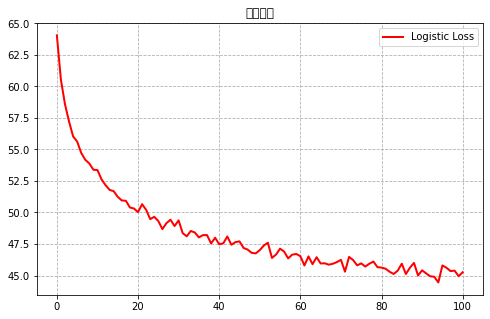

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test
test
test
total_test_accuracy: tensor(0.8542, device='cuda:0')
acc_test_each_k: tensor(0.8542, device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9208, device='cuda:0')
Training Epoch: 0, total loss: 45.643897
total_train_accuracy: tensor(0.9021, device='cuda:0')
Training Epoch: 1, total loss: 46.216918
total_train_accuracy: tensor(0.9229, device='cuda:0')
Training Epoch: 2, total loss: 45.268938
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 3, total loss: 45.182409
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 4, total loss: 44.907625
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 5, total loss: 44.674940
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 6, total loss: 44.444976
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 7, total loss: 45.004542
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 8, total loss: 44.991088
total_train_

total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 85, total loss: 43.296207
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 86, total loss: 43.876127
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 87, total loss: 43.952988
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 88, total loss: 43.486501
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 89, total loss: 43.555663
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 90, total loss: 43.635295
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 91, total loss: 42.792780
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 92, total loss: 43.364857
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 93, total loss: 43.003577
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 94, total loss: 43.711964
total_train_accuracy: tensor(0.9625, dev

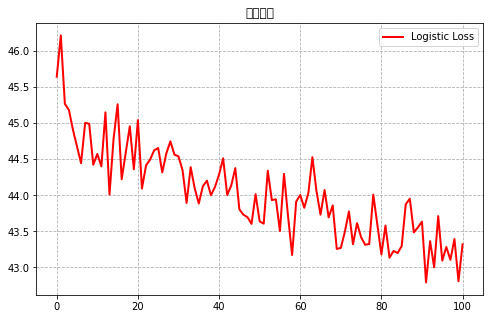

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 0, total loss: 43.593523
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 1, total loss: 43.565383
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 2, total loss: 43.942653
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 3, total loss: 43.905653
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 4, total loss: 43.337167
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 5, total loss: 42.843294
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 6, total loss: 43.246589
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 7, total loss: 43.107244
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 8, total loss: 43.082771
total_train_accuracy

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 85, total loss: 42.535301
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 86, total loss: 42.900653
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 87, total loss: 42.868698
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 88, total loss: 43.395797
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 89, total loss: 42.547250
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 90, total loss: 43.086744
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 91, total loss: 42.883617
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 92, total loss: 43.023922
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 93, total loss: 43.160139
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 94, total loss: 42.832367
total_train_accuracy: tensor(0.9750, dev

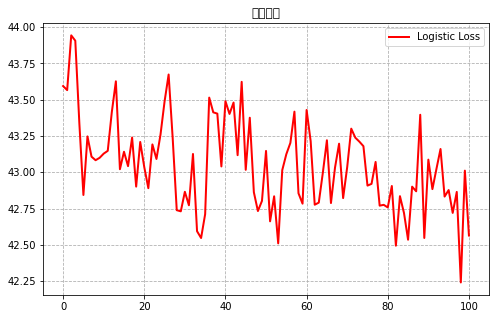

test
test
test
total_test_accuracy: tensor(0.9583, device='cuda:0')
acc_test_each_k: tensor(0.9583, device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 0, total loss: 43.092414
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 1, total loss: 42.962896
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 2, total loss: 42.960966
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 3, total loss: 43.036998
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 4, total loss: 43.241411
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 5, total loss: 42.767656
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 6, total loss: 43.183010
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 7, total loss: 43.282670
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 8, total loss: 42.867045
total_train_

total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 85, total loss: 42.703053
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 86, total loss: 42.404515
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 87, total loss: 42.934780
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 88, total loss: 42.447342
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 89, total loss: 42.513777
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 90, total loss: 42.333630
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 91, total loss: 42.756317
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 92, total loss: 42.565776
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 93, total loss: 42.458699
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 94, total loss: 42.628197
total_train_accuracy: tensor(0.9833, dev

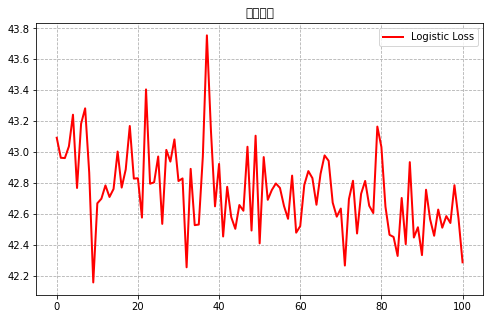

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 0, total loss: 42.679854
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 1, total loss: 43.105102
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 2, total loss: 42.287922
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 3, total loss: 42.579514
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 4, total loss: 42.915793
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 5, total loss: 42.562108
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 6, total loss: 42.783412
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 7, total loss: 42.863631
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 8, total loss: 43.295115
total_train_accuracy

total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 84, total loss: 42.065154
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 85, total loss: 42.453535
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 86, total loss: 42.163696
total_train_accuracy: tensor(0.9938, device='cuda:0')
Training Epoch: 87, total loss: 42.101232
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 88, total loss: 42.328773
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 89, total loss: 42.613525
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 90, total loss: 42.616393
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 91, total loss: 42.745193
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 92, total loss: 42.790937
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 93, total loss: 42.319207
total_train_accuracy: tensor(0.9771, dev

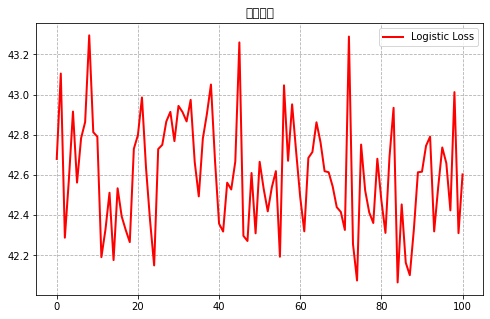

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 0, total loss: 42.794972
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 1, total loss: 42.971468
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 2, total loss: 43.046548
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 3, total loss: 42.537589
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 4, total loss: 42.529535
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 5, total loss: 42.614308
total_train_accuracy: tensor(0.9896, device='cuda:0')
Training Epoch: 6, total loss: 42.108172
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 7, total loss: 42.332475
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 8, total loss: 42.562141
total_train_accuracy

total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 85, total loss: 43.015240
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 86, total loss: 42.484351
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 87, total loss: 42.419440
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 88, total loss: 42.485935
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 89, total loss: 42.512056
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 90, total loss: 42.415049
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 91, total loss: 42.430992
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 92, total loss: 42.196212
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 93, total loss: 42.302259
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 94, total loss: 43.036171
total_train_accuracy: tensor(0.9771, dev

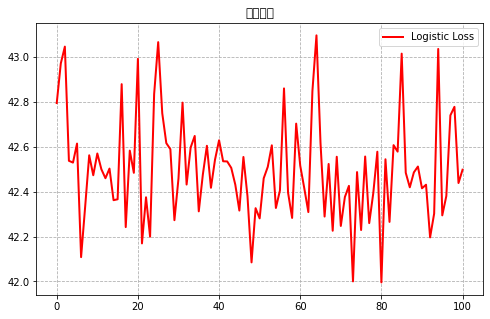

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 0, total loss: 42.645978
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 1, total loss: 42.504767
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 2, total loss: 42.182241
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 3, total loss: 42.207662
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 4, total loss: 42.034821
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 5, total loss: 42.606775
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 6, total loss: 42.385227
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 7, total loss: 41.998749
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 8, total loss: 42.430575
total_train_accuracy

total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 85, total loss: 42.607098
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 86, total loss: 42.047483
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 87, total loss: 42.322583
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 88, total loss: 42.073182
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 89, total loss: 42.558883
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 90, total loss: 41.970339
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 91, total loss: 42.218149
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 92, total loss: 42.494040
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 93, total loss: 42.364220
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 94, total loss: 42.153765
total_train_accuracy: tensor(0.9813, dev

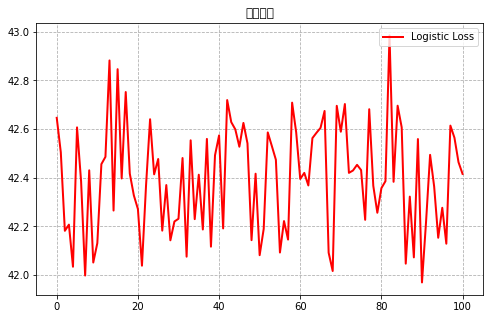

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 0, total loss: 42.260091
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 1, total loss: 42.584682
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 2, total loss: 42.324576
total_train_accuracy: tensor(0.9896, device='cuda:0')
Training Epoch: 3, total loss: 42.129282
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 4, total loss: 42.066781
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 5, total loss: 42.242978
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 6, total loss: 43.016972
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 7, total loss: 42.437035
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 8, total loss: 42.335884
total_train_accuracy

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 85, total loss: 42.094835
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 86, total loss: 42.278141
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 87, total loss: 42.392311
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 88, total loss: 42.194080
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 89, total loss: 42.374256
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 90, total loss: 42.482488
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 91, total loss: 42.273576
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 92, total loss: 42.317002
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 42.376545
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 94, total loss: 42.105004
total_train_accuracy: tensor(0.9646, dev

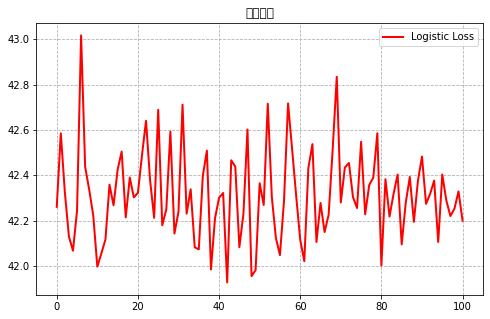

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 0, total loss: 42.726644
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 1, total loss: 42.973719
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 2, total loss: 41.881141
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 3, total loss: 42.536397
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 4, total loss: 41.961365
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 5, total loss: 42.295750
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 6, total loss: 42.952308
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 7, total loss: 42.653499
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 8, total loss: 42.069083
total_train_accuracy

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 85, total loss: 42.140731
total_train_accuracy: tensor(0.9896, device='cuda:0')
Training Epoch: 86, total loss: 41.871600
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 87, total loss: 41.791489
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 88, total loss: 42.332535
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 89, total loss: 42.306222
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 90, total loss: 42.448168
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 91, total loss: 42.345648
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 92, total loss: 42.108569
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 93, total loss: 42.173915
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 94, total loss: 42.225832
total_train_accuracy: tensor(0.9792, dev

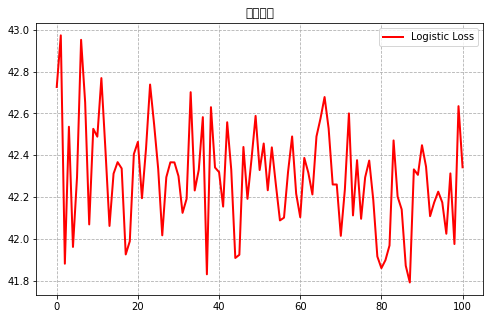

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 0, total loss: 42.478942
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 1, total loss: 42.422438
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 2, total loss: 42.001454
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 3, total loss: 41.987238
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 4, total loss: 42.568584
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 5, total loss: 42.129089
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 6, total loss: 42.182410
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 7, total loss: 42.205319
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 8, total loss: 42.509197
total_train_accuracy

total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 85, total loss: 41.791521
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 86, total loss: 42.547188
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 87, total loss: 42.701361
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 88, total loss: 42.126757
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 89, total loss: 42.102312
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 90, total loss: 42.476935
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 91, total loss: 42.162492
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 92, total loss: 42.493910
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 93, total loss: 42.023269
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 94, total loss: 41.946552
total_train_accuracy: tensor(0.9875, dev

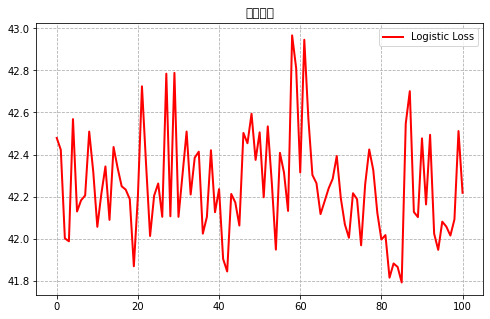

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
[tensor(0.8542, device='cuda:0'), tensor(1., device='cuda:0'), tensor(0.9583, device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
[array(0.8541667, dtype=float32), array(1., dtype=float32), array(0.9583334, dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]
acc_test_metrics: 0.98125


In [5]:
model=model5
K=10
test_metrics=[]
train_loss_total_list=[]
for ki in range(K):
    trainset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_train_val_info.csv',K=K, n_class=nfm_config['n_class'],ki=ki,  typ='train', transform=None, rand=True)
    valset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_train_val_info.csv', K=K,n_class=nfm_config['n_class'],ki=ki,  typ='val', transform=None, rand=True)
    train_loader = data.DataLoader(
         dataset=trainset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size'],
         shuffle=True)
    val_loader = data.DataLoader(
         dataset=valset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
    
    model_path='models/ConvAttMLP/30'
    #BATCH_SIZE=batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=nfm_config['lr'], weight_decay=nfm_config['l2_regularization'])
    #total = 0
    
    
    loss_func=torch.nn.CrossEntropyLoss()
    
    num=0
   
    
    epoches=101
    for epoch_id in range(epoches):
          
        
        
        train_loss_total,acc_train=train_epoch(model,train_loader,nfm_config['batch_size'],optimizer,loss_func)
        train_loss_total_list.append(train_loss_total)#
        if epoch_id %20==0:
            num=num+1
            #path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pkl')
            #torch.save(model.state_dict(),path)
            # 保存模型
            
            path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pt')##################pt
            torch.save(model.state_dict(),path)
            #torch.save(model.state_dict(),path)
    print("the ",ki," epoch ends")
    plotLoss(train_loss_total_list,epoches)
    train_loss_total_list=[]
    acc_test=val_epoch(model,val_loader,nfm_config['batch_size'],optimizer)
    print("acc_test_each_k:",acc_test)
    test_metrics.append(acc_test)

print(test_metrics)
#test_metrics=test_metrics.tolist()
test_metrics=[x.cpu().detach().numpy() for x in test_metrics]
print(test_metrics)
acc_test_metrics=np.mean(test_metrics) 
print("acc_test_metrics:",acc_test_metrics)
       


MLP5(
  (bn0): BatchNorm1d(172, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=172, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
138 173
f1_score:  %.4f 0.8898728873083878
accuracy_score: 0.8913043478260869
recall_score: 0.8846524934760228
pre_recall: 0.9144423360742147
n_classes: 9


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

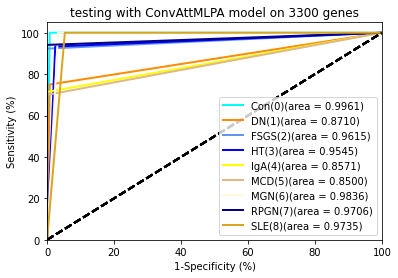

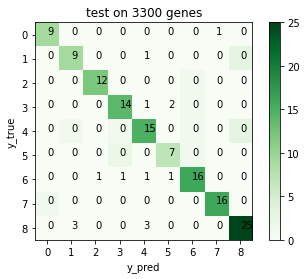

In [6]:
import torch

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'
path='models/ConvAttMLP/30/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=MLP5()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with ConvAttMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()